# Tutorial on Intrinsic dimension estimation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from duly import data
from duly.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph


%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [15]:

# import a test set
X = np.random.multivariate_normal([0, 0], [[1, 0.99],[ 0.99, 1]], size = (1000,))


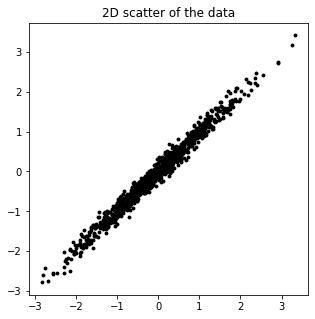

In [17]:
plt.figure(figsize = (5, 5))
plt.title('2D scatter of the data')
plt.scatter(X[:,0],X[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [18]:
# initialise the Data class
_data = data.Data(X)


In [19]:
# estimate ID
_data.compute_id_2NN()


Computation of the distances up to 999 NNs started
Computation of the distances finished
ID estimation finished: selecting ID of 1.922


In [20]:
 ids_scaling, ids_scaling_std, r2s_scaling = _data.return_id_scaling()

TypeError: _mus_scaling_reduce_func() got multiple values for argument 'range_scaling'

In [ ]:
        # array of ids (as a function of the average distance to a point)
        ids_scaling = np.empty(mus.shape[1])
        # array of error estimates (via fisher information)
        ids_scaling_std = np.empty(mus.shape[1])
        # array of average 'first' and 'second' neighbor distances, relative to each id estimate
        r2s_scaling = np.mean(r2s, axis=0)

        # compute IDs via maximum likelihood (and their error) for all the scales up to range_scaling
        for i in range(mus.shape[1]):
            n1 = 2 ** i
            id = ut._argmax_loglik(
                self.dtype, d0, d1, mus[:, i], n1, 2 * n1, self.N, eps=1.0e-7
            )
            ids_scaling[i] = id
            ids_scaling_std[i] = (
                1 / ut._fisher_info_scaling(id, mus[:, i], n1, 2 * n1)
            ) ** 0.5

        return ids_scaling, ids_scaling_std, r2s_scaling